(537, 691, 3)


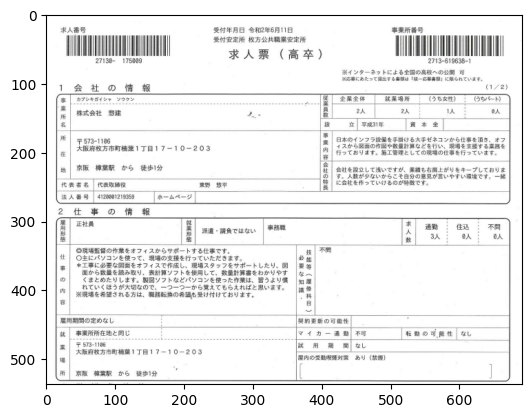

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

root_path = os.getcwd()
img_path = root_path+"\\configs\\image.png"
input_img = cv2.imread(img_path)
print(input_img.shape)
plt.imshow(input_img)

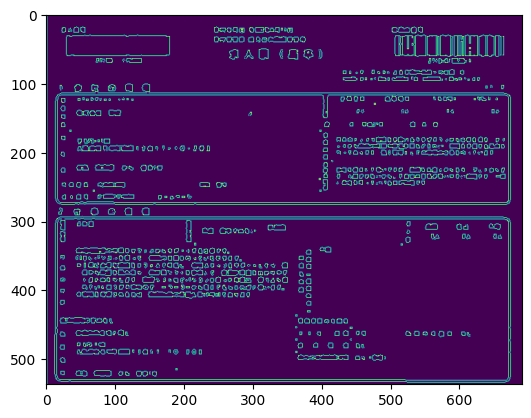

In [2]:

img = input_img.copy()

# Convert to Gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Make GaussianBlur (Normalized the colors)
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Perform Thresholding (Weak lines are disappeared)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

# Perform Bilateral Filter
gray = cv2.bilateralFilter(thresh, 1, 100, 150)

# Perform Canny Edges Detections (Clear lines are become more clear)
imgThreshold = cv2.Canny(gray, 20, 250)



plt.imshow(imgThreshold)


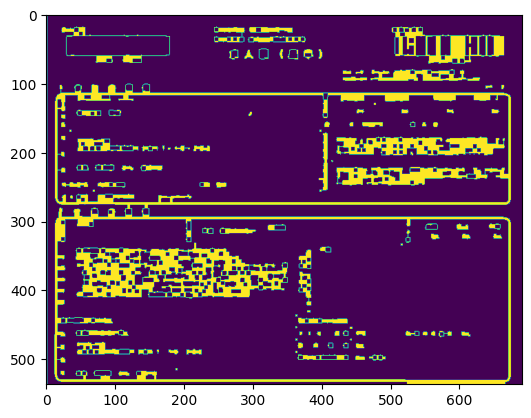

In [3]:
MORPH = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (MORPH, MORPH))
closed = cv2.morphologyEx(imgThreshold, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed)

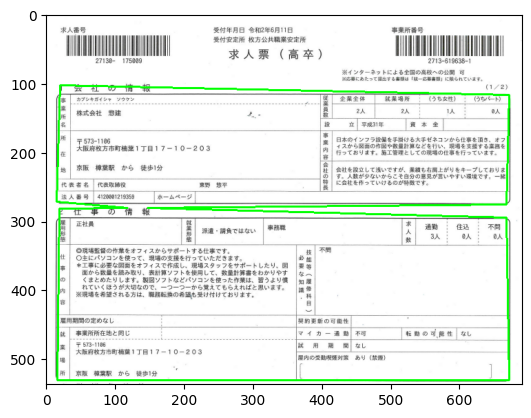

In [9]:


# FIND ALL CONTOURS
contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rgb = img.copy()
rect_list = []

for i in contours:
    area = cv2.contourArea(i)

    if area > 8000:
        peri = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        cv2.drawContours(img, [approx], -1, (0, 255, 0), 2)
        rect_list.append(approx)
plt.imshow(img)

In [10]:
rect_list

[array([[[ 20, 103]],
 
        [[ 15, 272]],
 
        [[118, 281]],
 
        [[ 19, 282]],
 
        [[ 16, 531]],
 
        [[672, 531]],
 
        [[668, 295]],
 
        [[147, 281]],
 
        [[668, 276]],
 
        [[672, 117]]], dtype=int32)]

In [20]:
line_points = []
for cur_rect in rect_list[0]:
    x = cur_rect[0][0]
    y = cur_rect[0][1]
    line_points.append([x,y])
    


10